##### Models Performance

In [17]:
import pandas as pd 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import networkx as nx
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import statistics

In [19]:
nodes=pd.read_csv('nodes_definitivo.csv')
edges=pd.read_csv('Edges_df6.csv')

In [15]:
# Prima delle valutazioni è necessario rimuovere gli elementi  esterni al giant component
nodes_eval=nodes[nodes["Giant_Component"]==1]

In [13]:
class Evaluations:

    def __init__(self, df, clusters_col_name):
        self.df=df
        self.clusters_col_name=clusters_col_name

    def conf_matrix(self):
        conf_mat=confusion_matrix(list(self.df.gruppo), list(self.df[self.clusters_col_name]))
        df_conf_norm = pd.DataFrame(conf_mat)
        df_conf_norm_r=pd.DataFrame(conf_mat/np.array( [conf_mat.sum(axis=1),conf_mat.sum(axis=1),conf_mat.sum(axis=1)]).T)
        plt.matshow(df_conf_norm_r, cmap='Reds')
        plt.colorbar()

        for (i, j), z in np.ndenumerate(df_conf_norm.to_numpy()):
            plt.text(j, i, '{:0.0f}'.format(z), ha='center', va='center')

        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        plt.show()

    def metric(self):
        m=metrics.classification_report(list(self.df.gruppo), list(self.df[self.clusters_col_name]), digits=3)
        print(m)

In [16]:
eval_eigen=Evaluations(nodes_eval,"cluster_eigen")
eval_eigen.metric()

              precision    recall  f1-score   support

           1      0.478     0.647     0.550      3010
           2      0.048     0.025     0.033      2180

    accuracy                          0.386      5190
   macro avg      0.263     0.336     0.291      5190
weighted avg      0.298     0.386     0.333      5190



In [60]:
eval_kmeans=Evaluations(nodes_eval,"cluster_kmeans")
eval_kmeans.metric()

              precision    recall  f1-score   support

           1      0.514     0.758     0.612      3010
           2      0.025     0.009     0.013      2180

    accuracy                          0.443      5190
   macro avg      0.270     0.383     0.313      5190
weighted avg      0.309     0.443     0.361      5190



In [61]:
eval_kmeans=Evaluations(nodes_eval,"cluster_GN")
eval_kmeans.metric()

              precision    recall  f1-score   support

           1      0.911     0.961     0.935      3010
           2      0.941     0.870     0.904      2180

    accuracy                          0.923      5190
   macro avg      0.926     0.915     0.920      5190
weighted avg      0.924     0.923     0.922      5190



#### Valutazione Grafo

In [20]:
#ricreiamo la rete per il solo giant component
g_nx=nx.from_pandas_edgelist(edges,source='Source',target='Target')
component_subgraph_list = list(nx.connected_components(g_nx))
largest_component = list(max(component_subgraph_list,key=len))
nodes_list=list(nodes.Id)
new_edges=edges[(edges['Source'].isin(largest_component)) & (edges['Target'].isin(largest_component))]

In [21]:
#creazione grafo in networkx della Giant Component
G_directed=nx.from_pandas_edgelist(new_edges,source='Source',target='Target',create_using=nx.DiGraph())
G_nx=nx.from_pandas_edgelist(new_edges,source='Source',target='Target')

In [22]:
#numerosità del grafo completo e giant component
nodes.groupby("hashtags")["gruppo"].count()
nodes[nodes["Giant_Component"]==1].groupby("hashtags")["gruppo"].count()

hashtags
#NoGreenPass        1545
#vaccinatevi        1205
@CasaPoundItalia     297
@EnricoLetta         975
@matteosalvinimi    1168
Name: gruppo, dtype: int64

Assortativity

In [ ]:
#Assortativity per la sola giant component
nx.degree_pearson_correlation_coefficient(G_directed)

-0.20792062392886407

La nostra rete è quindi disassortativa:
- Hubs tend to connect to small nodes.
- Disassortative networks have difficulty forming a giant
component (ops? ahahah)
- Hub removal is more damaging in disassortative networks, as in these the
hubs connect to many small-degree nodes, which fall off the network
once a hub is deleted.

Altri indici

In [24]:
#Structural cohesion:
# Connectivity measures the minimum number of elements (vertices or edges) that must be removed to 
# disconnect the graph
# edge connectivity
print(nx.edge_connectivity(G_nx))
#print(nx.edge_connectivity(G_directed))

1


In [ ]:
#node connectivity
print(nx.node_connectivity(G_nx))
#print(nx.node_connectivity(G_directed))

1
0


In [25]:
#density
#The density of a graph is a measure of how many ties between actors exist compared to how many 
#ties between actors are possible. A dense graph is a graph in which the number of edges is close 
#to the maximal number of edges. 
#NB: The density is 0 for a graph without edges and 1 for a complete graph

#print(nx.density(G_nx))
print(nx.density(G_directed))
#il nostro grafo è sparso

0.000270692672471892


In [ ]:
#print(nx.eccentricity(g_nx)) grafo non connesso, non si può calcolare l'eccentricity
# It is defined as the maximum distance of one vertex from other vertex. The maximum distance 
# between a vertex to all other vertices is considered as the eccentricity of the vertex.
eccentricity=nx.eccentricity(G_nx)

In [ ]:
#The radius of G is the value of the smallest eccentricity.
nx.radius(G_nx)
#min(eccentricity.values())

7

In [ ]:
#The diameter of G is the value of the greatest eccentricity.
nx.diameter(G_nx)
#max(eccentricity.values())

14

In [ ]:
#reciprocity is a measure of the likelihood of vertices in a directed network to be mutually 
# linked
overall_reciprocity=nx.overall_reciprocity(G_directed)
overall_reciprocity

# 0 -> non ci sono scambi di retweet?

0.0035665294924554186

In [ ]:
ciao

Degree Analysis (HUBS & Spamm Users)

In [ ]:
#DEGREE
#Degree is a simple centrality measure that counts how many neighbors a node has. 
# If the network is directed, we have two versions of the measure: 
# in-degree is the number of in-coming links, or the number of predecessor nodes; 
# out-degree is the number of out-going links, or the number of successor nodes.

In [26]:
out_degrees=dict(G_directed.out_degree())
out_degrees_sort=dict(sorted(out_degrees.items(), key=lambda item: item[1], reverse= True))
twitters=pd.DataFrame(list(out_degrees_sort.items()),columns=("id_utente","rt_fatti"))
twitters=pd.merge(twitters,nodes[["Id","Label","hashtags","Giant_Component"]],left_on="id_utente",right_on="Id",how="left")
twitters.drop("Id",axis=1,inplace=True)
twitters.head(20)
#possiamo notare che gli utenti più attivi siano quasi tutti appartenenti all'hashtag @matteosalvinimi

,id_utente,rt_fatti,Label,hashtags,Giant_Component
0,366660837,38,_fiorucci,@matteosalvinimi,1
1,810235254870937600,32,ferillo2,@matteosalvinimi,1
2,1174780873075544069,26,rosaroccaforte,@matteosalvinimi,1
3,1042691054,26,MastroRadu,@matteosalvinimi,1
4,2535751839,24,MarySpes,@matteosalvinimi,1
5,358626243,24,robymark1,@matteosalvinimi,1
6,1382258084567998469,20,Olindo35055898,@CasaPoundItalia,1
7,354778269,19,katakhon,@matteosalvinimi,1
8,1310209976,17,Ecatetriformis,@EnricoLetta,1
9,1409830264977645570,14,Luckyma89652325,@matteosalvinimi,1


In [27]:
#twitters.to_csv("twitters.csv",index=False)

In [ ]:
#percentuale di utenti che hanno effettuato retweet<=5
twitters[twitters["rt_fatti"]<=5]["rt_fatti"].count()/len(twitters)

0.9780346820809248

In [ ]:
#percentuale di appartenenza degli utenti che hanno effettuato ritweet <=5
twitters[twitters["rt_fatti"]<=5].groupby("hashtags")["rt_fatti"].count()/twitters[twitters["rt_fatti"]<=5]["rt_fatti"].count()

hashtags
#NoGreenPass        0.303191
#vaccinatevi        0.237392
@CasaPoundItalia    0.057920
@EnricoLetta        0.187746
@matteosalvinimi    0.213751
Name: rt_fatti, dtype: float64

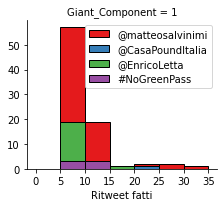

In [28]:
bins=np.arange(0, 40, 5)
g = sns.FacetGrid(twitters[twitters["rt_fatti"]>5], col="Giant_Component", hue="hashtags", palette="Set1", col_wrap=2)
g.map(plt.hist, 'rt_fatti', bins=bins, ec="k")
plt.xlabel("Ritweet fatti")
g.axes[-1].legend()
plt.xticks(np.arange(0, 40, 5))

plt.show()

In [31]:
twitters.head(30)

,id_utente,rt_fatti,Label,hashtags,Giant_Component
0,366660837,38,_fiorucci,@matteosalvinimi,1
1,810235254870937600,32,ferillo2,@matteosalvinimi,1
2,1174780873075544069,26,rosaroccaforte,@matteosalvinimi,1
3,1042691054,26,MastroRadu,@matteosalvinimi,1
4,2535751839,24,MarySpes,@matteosalvinimi,1
5,358626243,24,robymark1,@matteosalvinimi,1
6,1382258084567998469,20,Olindo35055898,@CasaPoundItalia,1
7,354778269,19,katakhon,@matteosalvinimi,1
8,1310209976,17,Ecatetriformis,@EnricoLetta,1
9,1409830264977645570,14,Luckyma89652325,@matteosalvinimi,1


In [30]:
#percentuale di appartenenza dei top30 utenti più attivi
twitters.head(30).groupby("hashtags")["rt_fatti"].count()/twitters.head(30)["rt_fatti"].count()

hashtags
#NoGreenPass        0.100000
@CasaPoundItalia    0.033333
@EnricoLetta        0.066667
@matteosalvinimi    0.800000
Name: rt_fatti, dtype: float64

In [ ]:
#df dei gradi entranti di ciascun nodo
df_gradi_in=pd.DataFrame(in_degrees.items(),columns=["nodi","grado"])

In [ ]:
#distribuzione dei nodi per i 5 gradi più ricorrenti
df_gradi_in.groupby("grado").count().head()

,nodi
grado,
0,4468
1,299
2,127
3,66
4,29


In [ ]:
#percentuale di nodi con grado=0 (nessun retweet ricevuto)
round(df_gradi_in[df_gradi_in["grado"]==0]["grado"].count()/df_gradi_in["grado"].count(),4)

0.8609

In [ ]:
#df dei gradi entranti di ciascun nodo
df_gradi_out=pd.DataFrame(out_degrees.items(),columns=["nodi","grado"])
round(df_gradi_out[df_gradi_out["grado"]==0]["grado"].count()/df_gradi_out["grado"].count(),4)

0.0925

In [1]:
import matplotlib.pyplot as plt
#distribuzione numero del numero dei retweet ricevuti in un range tra 5 e 100
def plot_in_degree_dist(G):
    bins=np.arange(10,1000,5)  
    degrees = sorted([G.in_degree(n) for n in G.nodes()])
    plt.hist(degrees, bins, color='green')
    plt.ylabel('utenti')
    plt.xlabel('retweet ricevuti (range:5-100)')
    plt.title('Distribuzione retweet ricevuti')
    plt.show()

plot_in_degree_dist(G_directed)

# da questo plot possiamo farci un idea della distribuzione degli hub 
# (nodi con un numero di archi entranti anomalo rispetto al resto della rete )

NameError: name 'G_directed' is not defined

In [ ]:
in_degrees=dict(G_directed.in_degree())
in_degrees_sort=dict(sorted(in_degrees.items(), key=lambda item: item[1], reverse= True))
HUBS=pd.DataFrame(list(in_degrees_sort.items()),columns=("id_utente","rt_ricevuti"))
HUBS=pd.merge(HUBS,nodes[["Id","Label","hashtags"]],left_on="id_utente",right_on="Id",how="left")
HUBS.drop("Id",axis=1,inplace=True)
HUBS.head(5)

,id_utente,rt_ricevuti,Label,hashtags
0,1364298062919794688,1080,Lorenzo62752880,#NoGreenPass
1,22038676,579,mariannaaprile,#vaccinatevi
2,231902290,415,Cartabellotta,#vaccinatevi
3,270839361,332,matteosalvinimi,@matteosalvinimi
4,215699843,245,CasaPoundItalia,@CasaPoundItalia


In [ ]:
print(min(in_degrees_sort.values()))
print(max(in_degrees_sort.values()))

0
1080


Centrality

In [ ]:
#The in-degree centrality for a node v is the fraction of nodes its incoming edges are connected to
#top10 dei nodi con il maggior numero di archi entranti (i più retwettati)--> HUBS
in_degree_centrality=nx.in_degree_centrality(G_directed)
in_degree_centrality_sort=dict(sorted(in_degree_centrality.items(), key=lambda item: item[1], reverse= True))
top10_IN_C=list(in_degree_centrality_sort.items())[:10]
top10_IN_C

[(1364298062919794688, 0.20813258816727692),
 (22038676, 0.11158219310079012),
 (231902290, 0.0799768741568703),
 (270839361, 0.06398149932549624),
 (215699843, 0.047215263056465596),
 (1238800491632607232, 0.039892079398728075),
 (4882542093, 0.028521873193293502),
 (1302616789348691968, 0.027943727115051067),
 (419622371, 0.027558296396222776),
 (1434532915417919488, 0.021005974176141837)]

In [ ]:
#The out-degree centrality for a node v is the fraction of nodes its outcoming edges are connected to
#top10 dei nodi con il maggior numero di archi uscenti (chi ha retwittato di più)
out_degree_centrality=nx.out_degree_centrality(G_directed)
out_degree_centrality_sort=dict(sorted(out_degree_centrality.items(), key=lambda item: item[1], reverse= True))
top10_OUT_C=list(out_degree_centrality_sort.items())[:10]
top10_OUT_C

[(366660837, 0.007323183657737521),
 (810235254870937600, 0.0061668915012526495),
 (1174780873075544069, 0.005010599344767778),
 (1042691054, 0.005010599344767778),
 (2535751839, 0.004625168625939487),
 (358626243, 0.004625168625939487),
 (1382258084567998469, 0.003854307188282906),
 (354778269, 0.0036615918288687606),
 (1310209976, 0.00327616111004047),
 (1409830264977645570, 0.002698015031798034)]

In [ ]:
#CLOSENESS CENTRALITY
# of a node is a measure of centrality in a network, 
# calculated as the reciprocal of the sum of the length of the shortest paths between the node 
# and all other nodes in the graph. Thus, the more central a node is, the closer it is to all 
# other nodes.
closeness_centrality=nx.closeness_centrality(G_directed)

In [ ]:
#trovo i top5 utenti per closeness_centrality
closeness_centrality_sort=dict(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse= True))
top10_CC=pd.DataFrame(list(closeness_centrality_sort.items())[:5],columns=("id_utente","closeness centrality"))
top10_CC=pd.merge(top10_CC,nodes[["Id","Label"]],left_on="id_utente",right_on="Id",how="left")
top10_CC.drop("Id",axis=1,inplace=True)
top10_CC

,id_utente,closeness centrality,Label
0,1364298062919794688,0.199657,Lorenzo62752880
1,22038676,0.135710,mariannaaprile
2,231902290,0.080743,Cartabellotta
3,4882542093,0.057145,lordfed3
4,215699843,0.049076,CasaPoundItalia


In [ ]:
#BETWEENNESS CENTRALITY
#betweenness centrality is a measure of centrality in a graph based on shortest paths. 
#Centrality misura l’importanza di un nodo nelle «comunicazioni» con gli altri nodi e
#quindi l’ influenza all'interno di una rete in virtù del «controllo sulle informazioni» che passano,
#pertanto si riferisce a quanto un nodo sia di passaggio 
betweenness_centrality=nx.betweenness_centrality(G_nx)

In [ ]:
#trovo i top5 utenti per betweenness_centrality
betweenness_centrality_sort=dict(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse= True))
top5_BC=pd.DataFrame(list(betweenness_centrality_sort.items())[:5],columns=("id_utente","betweenness centrality"))
top5_BC=pd.merge(top5_BC,nodes[["Id","Label"]],left_on="id_utente",right_on="Id",how="left")
top5_BC.drop("Id",axis=1,inplace=True)
top5_BC

,id_utente,betweenness centrality,Label
0,1364298062919794688,0.468372,Lorenzo62752880
1,22038676,0.376630,mariannaaprile
2,231902290,0.171784,Cartabellotta
3,270839361,0.137820,matteosalvinimi
4,419622371,0.087509,EnricoLetta
